## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?


По сути: ничем. Да, только матрицу транспонировать.item-item-это численная модель, ALS - это приближение,которое
использует градиентный спуск и регуляризацию.

2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


Любые доли, если в них есть смысл: доля среди товаров клиента, доля среди группы товаров клиента,доля среди группы товаров определенных клиентов, доли среди всей группы товаров, доля среди всех товаров и т.п.

3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)


Практически нет

4. Мы рассматривали bm_25_weight. 
Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?

bm_25 - является одной из развовидностей tf-idf ,https://ru.wikipedia.org/wiki/Okapi_BM25, другие виды tf-idf,LabelEncoder

## Практическая часть


In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config inlinebackend.figure_format = 'svg'
# Для работы с матрицами
from scipy.sparse import csr_matrix
import timeit
# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from sklearn.preprocessing import LabelEncoder,StandardScaler

# Функции из 1-ого вебинара
import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [167]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    #print(flags)
    
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [168]:
%time
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

Wall time: 0 ns


In [169]:
data_train

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2282320,222,41297772783,635,1120741,1,0.59,304,0.00,1716,91,0.0,0.0
2282321,462,41297773713,635,993339,1,1.99,304,0.00,2040,91,0.0,0.0
2282322,462,41297773713,635,995242,1,1.00,304,-0.89,2040,91,0.0,0.0
2282323,462,41297773713,635,10180324,1,3.00,304,-0.29,2040,91,0.0,0.0


In [170]:
data.week_no.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35,
       34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95], dtype=int64)

In [171]:
item_features = pd.read_csv('product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [172]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [175]:



#ALL THE PROGRAM STATEMETNS

popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
stop = timeit.default_timer()
execution_time = stop - start

print(execution_time) #It returns time in sec

0.2817743000050541


In [184]:
# %%timeit -o
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)
# a=TimeitResult
# return 

C:\Users\dm-k2\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [185]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [186]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [187]:
W={}
R={}

In [358]:
W['base']=user_item_matrix

In [359]:
W['matrix_tf'] = tfidf_weight(user_item_matrix.T).T

In [360]:
st=StandardScaler()
W['matrix_st']=st.fit_transform(user_item_matrix)

In [361]:
W['matrix_bm'] = bm25_weight(user_item_matrix.T).T


In [362]:
def als(table=W['matrix_bm'],f=100,i=10,reg= 0.02):
    
    model = AlternatingLeastSquares(factors=f, 
                                        regularization=reg,
                                        iterations=3, 
                                        calculate_training_loss=True, 
                                        num_threads=1) # K - кол-во билжайших соседей

    model.fit(csr_matrix(table).T.tocsr(),  # На вход item-user matrix
              show_progress=False)

    

    return model 

In [202]:
def eval(data,model,w='matrix_bm'):
    result = data.groupby('user_id')['item_id'].unique().reset_index()
    result.columns=['user_id', 'actual']
    result[w]= result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
    res=result.apply(lambda row: precision_at_k(row[w], row['actual']), axis=1).mean()
    return res

In [365]:
Table= pd.DataFrame(columns=['train','test'])

for w in W.keys():
    model = als(W[w])
    result_train=eval(data_train,model,w)
    result_test=eval(data_test,model,w)
    Table.loc[w] = (result_train,result_test)


In [366]:
Table

,train,test
base,0.816727,0.181783
matrix_tf,0.811285,0.178746
matrix_st,0.633613,0.111949
matrix_bm,0.854582,0.194809


BM дает наивысшие показатели

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.GridSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [347]:
def make_plot(x1,x2,x_lab,y_lab,i):
    
    ax[i].plot(x1,x2,'r')
    ax[i].set_xlabel(x_lab,fontsize = 14, c = 'green')
    ax[i].set_ylabel(y_lab,fontsize = 14, c = 'green')
    ax[i].tick_params(labelsize=14)
    ax[i].grid(c='lightgrey')
    plt.subplots_adjust(hspace=0.5,wspace = 0.5)
    
  

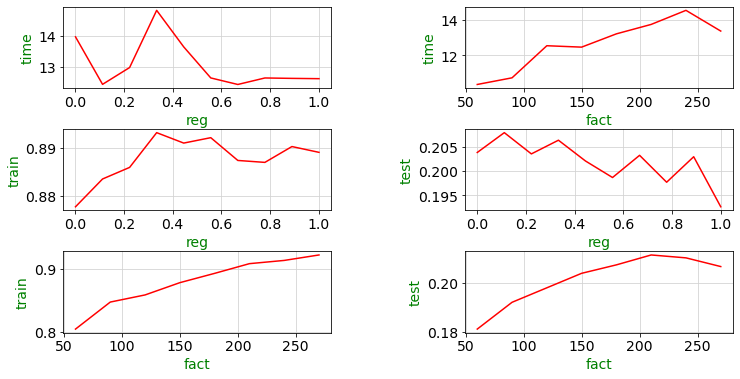

In [353]:
s1_train=[]
s1_test=[]
s2_train=[]
s2_test=[]
t1=[]
t2=[]
sj1=np.linspace(0.001,1,10)
sj2=np.arange(60,300,30)

fig, ax = plt.subplots(nrows=3, ncols=2)
ax=ax.flatten()
# ax1,ax2, ax3, ax4=ax.flatten()
fig.set_size_inches(12,6)
# plt.subplots_adjust(hspace=0.5,wspace = 0.7)

for j in sj1:

    start = timeit.default_timer()
    model = als(f=150,reg=j, i=3)
    stop = timeit.default_timer()
    result_train=eval(data_train,model)
    result_test=eval(data_test,model)
    s1_train.append(result_train)
    execution_time = stop - start
#     s1_train.append(result_test)
    s1_test.append(result_test)
    t1.append(execution_time)
    

for j in sj2:

    start = timeit.default_timer()
    model = als(f=j,reg=0.02, i=3)
    stop = timeit.default_timer()
    result_train=eval(data_train,model)
    result_test=eval(data_test,model)
#     s1.append(result_train)
    execution_time = stop - start
    s2_train.append(result_train)
    s2_test.append(result_test)
    t2.append(execution_time)
m=['reg','fact','train','test','time']

make_plot(sj1,t1,m[0],m[4],0) 
make_plot(sj2,t2,m[1],m[4],1) 
make_plot(sj1,s1_train,m[0],m[2],2) 
make_plot(sj1,s1_test,m[0],m[3],3) 
make_plot(sj2,s2_train,m[1],m[2],4) 
make_plot(sj2,s2_test,m[1],m[3],5) 
    

С точки зрения оптимизации гиперпараметров, на тесте reg = 0.1 дает лучший результат, затем метрика начинает падать.
Что касается количества признаков, метрика растет на тесте до уровня 200, затем начинает падать.
    

**P.S.** Не пишите отписки в качестве выводов. Мне интресены Ваши рассуждения, трудности, с которыми Вы сталкнулись и что-то, что Вас удивило. Если выводы контринтуитивны - напишите об этом, в этом нет ничего страшного!